# Введение в нейронные сети

## Эпизод 1: Персептрон

Дмитрий Сошников

технологический евангелист, Microsoft

dmitryso@microsoft.com

Данная презентация представляет собой введение в нейронные сети. Идея однодневного мастер-класса основана на Neural Network Workshop в Microsoft Research Cambridge. Материал и фрагменты кода частично взяты из презентаций [Katja Hoffmann](https://www.microsoft.com/en-us/research/people/kahofman/), [Matthew Johnson](https://www.microsoft.com/en-us/research/people/matjoh/) и [Ryoto Tomioka](https://www.microsoft.com/en-us/research/people/ryoto/) из Microsoft Research Cambridge. [NeuroWorkshop](http://github.com/shwars/NeuroWorkshop) подготовлен [Дмитрием Сошниковым](http://blog.soshnikov.com), Microsoft Russia.

## Два взгляда на нейронные сети

 * Восходящий подход к искусственному интеллекту
 * Способ усложнения и комбинирования базовых алгоритмов машинного обучения
     - обучение с учителем (*supervised learning*)
     - обучение без учителя (*unsupervised learning*)

## Обучение с учителем

**Дано:**
  * Обучающая выборка $\mathbf{X} \in \mathbb{R}^{n \times k}$
    * $n$ - размер выборки
    * $x_i$ представлено вектором свойств размерности $k$
  * Известные значения целевой функции $\mathbf{Y}$ ($y_i$ соответствует вектору свойств $x_i$)
    * $\mathbf{Y} \in \mathbb{R}^{n \times 1}$ (задачи регрессии)
    * $\mathbf{Y} \in C^{n \times 1}$, где $y_i \in C$ (задачи классификации на $|C|$ классов)


## Задача

**Дано:**
  * Обучающая выборка $\mathbf{X} \in \mathbb{R}^{n \times k}$
  * Входные значение целевой функции $\mathbf{Y}$

**Необходимо построить:**
  * Функцию $f : \mathbf{X} \rightarrow \mathbf{Y}$ который _точно предсказывает_ значение целевой функции на новом наборе входных данных $\mathbf{X}_{new}$


In [1]:
%matplotlib inline
import pylab
from matplotlib import gridspec
from sklearn.datasets import make_classification
import numpy as np
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets


# pick the seed for reproducability - change it to explore the effects of random variations
np.random.seed(1)
import random

## Пример
Рассмотрим пример двухмерной задачи классификации на 2 класса. Примером такой задачи может быть классификация опухоли на 2 типа - доброкачественная и злокачественная, в зависимости от её размера и возраста.

In [2]:
n = 50
X, Y = make_classification(n_samples = n, n_features=2,
                           n_redundant=0, n_informative=2, flip_y=0)
Y = Y*2-1
X = X.astype(np.float32); Y = Y.astype(np.int32)

# Разбиваем на обучающую и тестовые выборки. В реальной жизни обучающая - 80% данных
train_x, test_x = np.split(X, [ n*8//10])
train_labels, test_labels = np.split(Y, [n*8//10])
print("Features:\n",train_x[0:4])
print("Labels:\n",train_labels[0:4])

Features:
 [[-1.74418378 -1.39520371]
 [ 2.59217834 -0.08124504]
 [ 0.92180622  0.91789985]
 [-0.84370178 -0.18738253]]
Labels:
 [-1 -1  1 -1]


In [3]:
def plot_dataset(suptitle, features, labels):
    # prepare the plot
    fig, ax = pylab.subplots(1, 1)
    #pylab.subplots_adjust(bottom=0.2, wspace=0.4)
    fig.suptitle(suptitle, fontsize = 16)
    ax.set_xlabel('$x_i[0]$ -- (feature 1)')
    ax.set_ylabel('$x_i[1]$ -- (feature 2)')

    colors = ['r' if l>0 else 'b' for l in labels]
    ax.scatter(features[:, 0], features[:, 1], marker='o', c=colors, s=100, alpha = 0.5)
    fig.show()

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


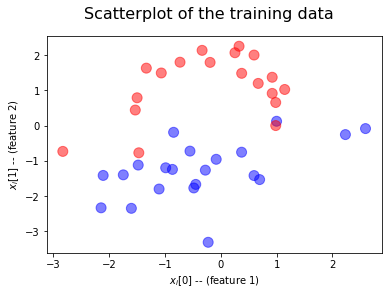

In [4]:
plot_dataset('Scatterplot of the training data', train_x, train_labels)

## Нейросети
<img src="https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/images/synapse-wikipedia.JPG" width="30%"/>
Искусственная нейросеть - это моделирование с той или иной точностью процессов, происходящих в мозге человека.
  * Моделируется в основном электрическая активность
  * Сильное упрощение модели, которое позволяет эффективно её вычислять



## Персептрон
<img style='margin: 10px;width: 30%;' src='https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/images/Rosenblatt-wikipedia.jpg' alt='Frank Rosenblatt' align='right'/>
Первая попытка реализовать нейронную сеть - 1957 г., Cornell Aeronautical Laboratory, Frank Rosenblatt. 

Реализация "в железе"

Цель - распознавание образов

Один нейрон, 400 входов от изображения 20x20, двоичный выход

## Персептрон

<img style='margin: 10px;width:30%' src='https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/images/Mark_I_perceptron_wikipedia.jpg' align='right' alt='The Mark 1 Perceptron' />

New York Times так об этом писала:

> the embryo of an electronic computer that [the Navy] expects will be able to walk, talk,
> see, write, reproduce itself and be conscious of its existence.

В основе - работы Warren McCullock и Walter Pitts 1943 года

Threshold Logic Unit - первая модель искусственного нейрона

## Мат.модель персептрона

На вход подаётся вектор $\mathbf{x}$, в этом случае выходное значение вычисляется как:

$$y(\mathbf{x}) = f(\mathbf{w}^{\mathrm{T}}\mathbf{x})$$

где $\mathbf{w}$ - вектор весов, $f$ - пороговая функция вида
$$
f(x) = \begin{cases}
         +1 & x \geq 0 \\
         -1 & x < 0
       \end{cases} \\
$$

## Алгоритм обучения

Для работы персептрона необходимо найти веса $\mathbf{w}$. Для этого мы используем и минимизируем **критерий персептрона**:

$$E(\mathbf{w}) = -\sum_{n \in \mathcal{M}}\mathbf{w}^{\mathrm{T}}\mathbf{x}_{n}t_{n}$$
 
  * $t_{n} \in \{-1, +1\}$ для отрицательных и положительных примеров соответственно
  * $\mathcal{M}$ - множество неправильно классифицированных примеров
  
Для обновления весов на каждом примере мы можем использовать градиент этой функции:

$$\mathbf{w}^{\tau + 1}=\mathbf{w}^{\tau} - \eta \nabla E(\mathbf{w}) = \mathbf{w}^{\tau} + \eta \mathbf{x}_{n} t_{n}$$

где $\eta$ - коэффициент, показывающий скорость обучения, $\tau\in\mathbb{N}$ - номер шага алгоритма

In [5]:
pos_examples = np.array([ [t[0],t[1],1] for i,t in enumerate(train_x) 
                          if train_labels[i]>0])
neg_examples = np.array([ [t[0],t[1],1] for i,t in enumerate(train_x) 
                          if train_labels[i]<0])
print(pos_examples[0:3])

[[ 0.92180622  0.91789985  1.        ]
 [-1.06435513  1.49764717  1.        ]
 [ 0.32839951  2.25677919  1.        ]]


```python
def train(positive_examples, negative_examples, num_iterations = 100):

    weights = [0,0,0]
        
    for i in range(num_iterations):
        pos = random.choice(positive_examples)
        neg = random.choice(negative_examples)

        z = np.dot(pos, weights)   
        if z < 0:
            weights = weights + weights.shape

        z  = np.dot(neg, weights)
        if z >= 0:
            weights = weights - weights.shape

    return weights
```

In [6]:
def train(positive_examples, negative_examples, num_iterations = 100):
    num_dims = positive_examples.shape[1]
    weights = np.zeros((num_dims,1)) # инициализируем веса
    
    pos_count = positive_examples.shape[0]
    neg_count = negative_examples.shape[0]
    
    report_frequency = 10
    
    for i in range(num_iterations):
        pos = random.choice(positive_examples)
        neg = random.choice(negative_examples)

        z = np.dot(pos, weights)   
        if z < 0:
            weights = weights + pos.reshape(weights.shape)

        z  = np.dot(neg, weights)
        if z >= 0:
            weights = weights - neg.reshape(weights.shape)
            
        if i % report_frequency == 0:             
            pos_out = np.dot(positive_examples, weights)
            neg_out = np.dot(negative_examples, weights)        
            pos_correct = (pos_out >= 0).sum() / float(pos_count)
            neg_correct = (neg_out < 0).sum() / float(neg_count)
            print("Iteration={}, pos correct={}, neg correct={}".format(i,pos_correct,neg_correct))

    return weights

In [7]:
wts = train(pos_examples,neg_examples)
print(wts.transpose())

Iteration=0, pos correct=0.7368421052631579, neg correct=0.9523809523809523
Iteration=10, pos correct=0.8947368421052632, neg correct=0.9523809523809523
Iteration=20, pos correct=0.8947368421052632, neg correct=0.8095238095238095
Iteration=30, pos correct=0.8947368421052632, neg correct=0.8571428571428571
Iteration=40, pos correct=0.8421052631578947, neg correct=1.0
Iteration=50, pos correct=1.0, neg correct=0.7142857142857143
Iteration=60, pos correct=0.8947368421052632, neg correct=0.6190476190476191
Iteration=70, pos correct=0.9473684210526315, neg correct=0.9523809523809523
Iteration=80, pos correct=0.8947368421052632, neg correct=0.9047619047619048
Iteration=90, pos correct=0.8947368421052632, neg correct=0.9047619047619048
[[-1.4287746   5.01984162 -1.        ]]


In [8]:
def plot_boundary(positive_examples, negative_examples, weights):
    if np.isclose(weights[1], 0):
        if np.isclose(weights[0], 0):
            x = y = np.array([-6, 6], dtype = 'float32')
        else:
            y = np.array([-6, 6], dtype='float32')
            x = -(weights[1] * y + weights[2])/weights[0]
    else:
        x = np.array([-6, 6], dtype='float32')
        y = -(weights[0] * x + weights[2])/weights[1]

    pylab.xlim(-6, 6)
    pylab.ylim(-6, 6)                      
    pylab.plot(positive_examples[:,0], positive_examples[:,1], 'bo')
    pylab.plot(negative_examples[:,0], negative_examples[:,1], 'ro')
    pylab.plot(x, y, 'g', linewidth=2.0)
    pylab.show()

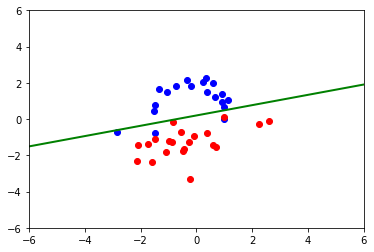

In [9]:
plot_boundary(pos_examples,neg_examples,wts)

## Проверяем на тестовой выборке

In [10]:
def accuracy(weights, test_x, test_labels):
    res = np.dot(np.c_[test_x,np.ones(len(test_x))],weights)
    return (res.reshape(test_labels.shape)*test_labels>=0).sum()/float(len(test_labels))

accuracy(wts, test_x, test_labels)

1.0

## Посмотрим, как меняется точность обучения

In [11]:
def train_graph(positive_examples, negative_examples, num_iterations = 100):
    num_dims = positive_examples.shape[1]
    weights = np.zeros((num_dims,1)) # инициализируем веса
    
    pos_count = positive_examples.shape[0]
    neg_count = negative_examples.shape[0]
    
    report_frequency = 15;
    snapshots = []
    
    for i in range(num_iterations):
        pos = random.choice(positive_examples)
        neg = random.choice(negative_examples)

        z = np.dot(pos, weights)   
        if z < 0:
            weights = weights + pos.reshape(weights.shape)

        z  = np.dot(neg, weights)
        if z >= 0:
            weights = weights - neg.reshape(weights.shape)
            
        if i % report_frequency == 0:             
            pos_out = np.dot(positive_examples, weights)
            neg_out = np.dot(negative_examples, weights)        
            pos_correct = (pos_out >= 0).sum() / float(pos_count)
            neg_correct = (neg_out < 0).sum() / float(neg_count)
            snapshots.append((np.copy(weights),(pos_correct+neg_correct)/2.0))

    return np.array(snapshots)

snapshots = train_graph(pos_examples,neg_examples)

def plotit(pos_examples,neg_examples,snapshots,step):
    fig = pylab.figure(figsize=(10,4))
    fig.add_subplot(1, 2, 1)
    plot_boundary(pos_examples, neg_examples, snapshots[step][0])
    fig.add_subplot(1, 2, 2)
    pylab.plot(np.arange(len(snapshots[:,1])), snapshots[:,1])
    pylab.ylabel('Accuracy')
    pylab.xlabel('Iteration')
    pylab.plot(step, snapshots[step,1], "bo")
    pylab.show()
def pl1(step): plotit(pos_examples,neg_examples,snapshots,step)

In [12]:
interact(pl1, step=widgets.IntSlider(value=0, min=0, max=len(snapshots)-1))

A Jupyter Widget

<function __main__.pl1>

## Ограниченность персептрона

Типичный пример нерешаемой задачи - **исключающее или** (XOR problem)

   | 0 | 1
---|---|---
 0 | 0 | 1
 1 | 1 | 0

In [25]:
pos_examples_xor = np.array([[1,0,1],[0,1,1]])
neg_examples_xor = np.array([[1,1,1],[0,0,1]])

snapshots_xor = train_graph(pos_examples_xor,neg_examples_xor,1000)
def pl2(step): plotit(pos_examples_xor,neg_examples_xor,snapshots_xor,step)

In [26]:
interact(pl2, step=widgets.IntSlider(value=0, min=0, max=len(snapshots)-1))

A Jupyter Widget

<function __main__.pl2>

## Сложный пример - MNIST

Modified National Institute of Standards and Technology

https://www.kaggle.com/c/digit-recognizer

  * Рукописные цифры, собранные с сотрудников института стандартов и учащихся, около 250 человек
  * 60000 обучающая выборка, 10000 тестовая выборка, собранная от разных групп
  * Изображения в градациях серого, 28x28

## Формат входной выборки

![MNIST Format](https://www.cntk.ai/jup/cntk103a_MNIST_input.png)

In [14]:
import pickle
import os
!rm *.pkl
!wget https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/Data/MNIST/mnist.pkl.gz
!gzip -d mnist.pkl.gz
        
with open('mnist.pkl', 'rb') as mnist_pickle:
    MNIST = pickle.load(mnist_pickle)

--2017-11-27 08:03:45--  https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/Data/MNIST/mnist.pkl.gz
Resolving webproxy (webproxy)... 10.72.8.104
Connecting to webproxy (webproxy)|10.72.8.104|:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 10392609 (9.9M) [application/octet-stream]
Saving to: 'mnist.pkl.gz'

mnist.pkl.gz        100%[===================>]   9.91M  8.39MB/s    in 1.2s    

2017-11-27 08:03:49 (8.39 MB/s) - 'mnist.pkl.gz' saved [10392609/10392609]



[  0   0 188 255  94   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0 191 250 253  93   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
1


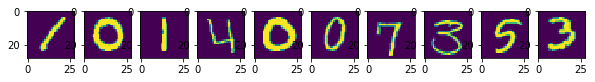

In [15]:
print(MNIST['Train']['Features'][0][130:180])
print(MNIST['Train']['Labels'][0])
features = MNIST['Train']['Features'].astype(np.float32) / 256.0
labels = MNIST['Train']['Labels']
fig = pylab.figure(figsize=(10,5))
for i in range(10):
    ax = fig.add_subplot(1,10,i+1)
    pylab.imshow(features[i].reshape(28,28))
pylab.show()

In [16]:
def set_mnist_pos_neg(positive_label, negative_label):
    positive_indices = [i for i, j in enumerate(MNIST['Train']['Labels']) 
                          if j == positive_label]
    negative_indices = [i for i, j in enumerate(MNIST['Train']['Labels']) 
                          if j == negative_label]

    positive_images = MNIST['Train']['Features'][positive_indices]
    negative_images = MNIST['Train']['Features'][negative_indices]

    fig = pylab.figure()
    ax = fig.add_subplot(1, 2, 1)
    pylab.imshow(positive_images[0].reshape(28,28), cmap='gray', interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])
    ax = fig.add_subplot(1, 2, 2)
    pylab.imshow(negative_images[0].reshape(28,28), cmap='gray', interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])
    pylab.show()
    
    return positive_images, negative_images

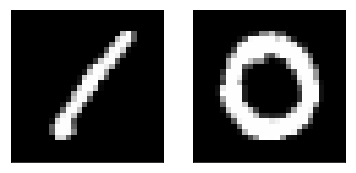

In [17]:
pos1,neg1 = set_mnist_pos_neg(1,0)

In [18]:
def plotit2(snapshots_mn,step):
    fig = pylab.figure(figsize=(10,4))
    ax = fig.add_subplot(1, 2, 1)
    pylab.imshow(snapshots_mn[step][0].reshape(28, 28), interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])
    pylab.colorbar()
    ax = fig.add_subplot(1, 2, 2)
    ax.set_ylim([0,1])
    pylab.plot(np.arange(len(snapshots_mn[:,1])), snapshots_mn[:,1])
    pylab.plot(step, snapshots_mn[step,1], "bo")
    pylab.show()
def pl3(step): plotit2(snapshots_mn,step)
def pl4(step): plotit2(snapshots_mn2,step)    

In [19]:
snapshots_mn = train_graph(pos1,neg1,1000)    
interact(pl3, step=widgets.IntSlider(value=0, min=0, max=len(snapshots_mn) - 1))

A Jupyter Widget

<function __main__.pl3>

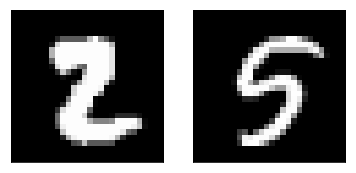

In [20]:
pos2,neg2 = set_mnist_pos_neg(2,5)

In [21]:
snapshots_mn2 = train_graph(pos2,neg2,1000)
interact(pl4, step=widgets.IntSlider(value=0, min=0, max=len(snapshots_mn2) - 1))

A Jupyter Widget

<function __main__.pl4>

## В чем разница?

Почему-то 1 и 0 разделяются намного лучше, чем 2 и 5. 

Для понимания причины, используем [метод главных компонент](https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%B3%D0%BB%D0%B0%D0%B2%D0%BD%D1%8B%D1%85_%D0%BA%D0%BE%D0%BC%D0%BF%D0%BE%D0%BD%D0%B5%D0%BD%D1%82).

**Идея**: выделяем из множества входных фич (784 шт.) подмножество меньшей размерности, которое позволяет максимально репрезентативно разделить множества примеров.

In [22]:
from matplotlib.mlab import PCA

def pca_analysis(positive_label, negative_label):
    positive_images, negative_images = set_mnist_pos_neg(positive_label, negative_label)
    M = np.append(positive_images, negative_images, 0)

    mypca = PCA(M, standardize = False)

    pos_points = mypca.project(positive_images[:200])
    neg_points = mypca.project(negative_images[:200])

    pylab.plot(pos_points[:,0], pos_points[:,1], 'bo')
    pylab.plot(neg_points[:,0], neg_points[:,1], 'ro')

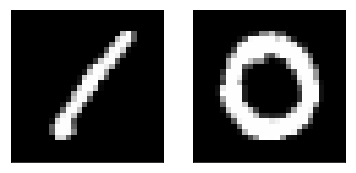

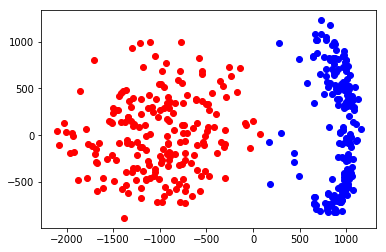

In [23]:
pca_analysis(1,0)

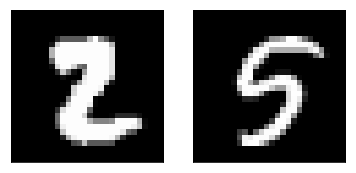

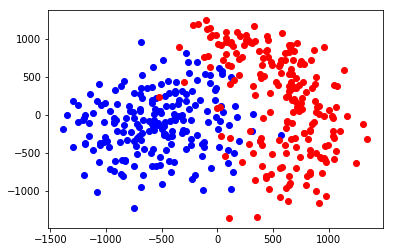

In [24]:
pca_analysis(2,5)

## Выводы

 * Мы научились создавать простейшую конфигурацию нейросети - однослойный персептрон
 * При этом такие сети уже могут решать весьма нетривиальные задачи
 * Тем не менее, однослойный персептрон по сути эквивалентен логистической регрессии, т.е. класс эффективно решаемых задач ограничен
 * В пространстве состояний однослойный персептрон может разделить два класса объектов гиперплоскостью